# Notes

- Ugh, we do have a confound in that the validation information is also coming from bad users... hmm.
- Can we predict the correctness of an individual label? (e.g., based on whether it has a tag, a severity rating, etc.)

# Imports

In [285]:
import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn stuff
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold

# Utility functions

In [420]:
map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']

map_group_to_marker = {'Anonymous':'o', 'Registered':'v', 'Researcher':'s', 'Turker':'*'}
map_quality_to_marker = {'Bad':'^', 'Good':'p', 'Neutral':'X', 'Very Bad':'d', 'Very Good':'P'}

map_markers = { 'role' : map_group_to_marker,
                'quality' : map_quality_to_marker,
                'user_quality_3bins': map_quality_to_marker,
                'user_quality_5bins': map_quality_to_marker}

def display_overview(df):
    grouped_by_role = df.groupby('role')

    df_result = grouped_by_role['audit_mission_count', 'meters_audited', 'n_label', 'n_validation_received'].sum()
    df_result['num_users'] = grouped_by_role['role'].count()

    # reorder cols: https://stackoverflow.com/a/13148611
    cols = df_result.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_result = df_result[cols]
    df_result['Avg Accuracy'] = grouped_by_role['accuracy'].mean()
    df_result['Med Accuracy'] = grouped_by_role['accuracy'].median()
    df_result['SD Accuracy'] = grouped_by_role['accuracy'].std()

    if 'user_quality_3bins' in df.columns:
        grouped_by_role_and_quality = df_users.groupby(['user_quality_3bins', 'role'])
        df_result['Bad'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Bad']
        df_result['Neutral'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Neutral']
        df_result['Good'] = grouped_by_role_and_quality['user_quality_3bins'].count()['Good']

    df_result.loc['Total'] = df_result.sum()
    
    int_cols = ['num_users', 'audit_mission_count', 'n_label', 'n_validation_received']
    
    if 'user_quality_3bins' in df.columns:
        int_cols.append(['Bad', 'Neutral', 'Good'])
    
    for col_name in int_cols:
        df_result[col_name] = df_result[col_name].fillna(0)
        df_result[col_name] = df_result[col_name].astype(int)
    
    df_result.at['Total', 'Avg Accuracy'] = df['accuracy'].mean()
    df_result.at['Total', 'Med Accuracy'] = df['accuracy'].median()
    df_result.at['Total', 'SD Accuracy'] = df['accuracy'].std()
    
    df_result.rename(columns={"n_validation_received": "Validations Received"}, inplace=True)
    
    #df_result2['meters_audited'] = df_result['meters_audited']
    display(df_result)

def plot_scatter(df, xcol_name, ycol_name, xlabel=None, ylabel=None, 
                 map_group_to_marker = None, xlim = None, ax = None,
                groupby='role'):
    groups = df.groupby(groupby)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    if map_group_to_marker is None:
        map_group_to_marker = map_markers[groupby]
    
    for name, group in groups:
        pairwise_corr = group[xcol_name].corr(group[ycol_name], method='pearson')
        #print(f"Corr of {xcol_name} to {ycol_name}: {cor}")
        ax.plot(group[xcol_name], group[ycol_name], marker=map_group_to_marker[name], 
                linestyle='', ms=10, alpha=0.65, label=f"{name} (r={pairwise_corr:0.2f})")
    ax.legend()
    
    if xlabel is None:
        xlabel = xcol_name
        
    if ylabel is None:
        ylabel = ycol_name
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(f"{xlabel} vs. {ylabel}")
    
    if xlim is not None:
        ax.set_xlim(xlim)
    #plt.show()
    return ax

def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues, figsize=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")

    # print(cm)
    if figsize is None:
        figsize = (12, 6)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #imshow displays data on a 2D raster
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


### FILE HANDLING ###
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def get_csv_filenames( path_to_dir, suffix=".csv" , include_path = True):
    filenames = listdir(path_to_dir)
    list_files = []
    for filename in filenames:
        filename_with_path = os.path.join(path_to_dir, filename)
        if filename.endswith(suffix):
            if include_path:
                list_files.append(filename_with_path)
            else:
                list_files.append(filename)
    return list_files
    
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Utility function to extract gesture name from filename
def extract_city_name(filename):
    just_filename = path_leaf(filename)
    start_split_index = just_filename.index('-', 2) + 1
    end_split_index = just_filename.index('-', start_split_index)
    return just_filename[start_split_index:end_split_index]

def read_and_parse_data_file(csv_file):
    df_users_for_city = pd.read_csv(csv_file) 
    # df_users_for_city.rename(columns = {'validation_count':'validations_received_count'}, inplace = True) 
    
    # Calculate accuracy column
    df_users_for_city['accuracy'] = ((df_users_for_city['n_validation_received'] - df_users_for_city['n_received_disagree']) / 
                                    df_users_for_city['n_validation_received'])
    
    df_users_for_city['n_received_curb_ramp_validations'] = df_users_for_city['n_received_curb_ramp_agree'] + \
                          df_users_for_city['n_received_curb_ramp_disagree'] + \
                          df_users_for_city['n_received_curb_ramp_unsure']
    df_users_for_city['curb_ramp_accuracy'] = ((df_users_for_city['n_received_curb_ramp_validations'] - df_users_for_city['n_received_curb_ramp_disagree']) / 
                                    df_users_for_city['n_received_curb_ramp_validations'])
        
    city_name = extract_city_name(csv_file).capitalize()
    df_users_for_city['city'] = city_name
    return df_users_for_city

def read_and_parse_data_files(csv_files, verbose = True):
    list_dfs = []
    for csv_file in csv_files:
        df = read_and_parse_data_file(csv_file)
        if verbose:
            print(f"Read in {len(df)} users from {csv_file}")
            #display(df_users.groupby('role')['role', 'high_quality_manual'].count())
            display_overview(df)
        list_dfs.append(df)
    df_users = pd.concat(list_dfs)
    return df_users

# Read in data

In [421]:
%%time

csv_files = get_csv_filenames('data')
df_users = read_and_parse_data_files(csv_files)

# make a copy of the original DataFrame just in case we need it. We'll save
# the cleaned one in the original df_users DataFrame
df_users_original = df_users.copy()

Read in 26 users from data\ml-cdmx-stats.csv


,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,10,9,1662.643676,147,134,0.719672,0.887500,0.391543
Registered,14,241,64375.593824,4849,2251,0.888056,0.906852,0.107301
Researcher,2,22,4773.490351,350,252,0.898148,0.898148,0.065473
Total,26,272,70811.727852,5346,2637,0.824069,0.902857,0.261610


Read in 101 users from data\ml-columbus-stats.csv


,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,32,60,12642.616483,1054,555,0.905738,0.938095,0.122910
Registered,65,519,134980.889635,10793,3324,0.862398,0.884615,0.106188
Researcher,4,43,11132.630550,1766,684,0.953836,0.951150,0.036309
Total,101,622,158756.136669,13613,4563,0.879751,0.902174,0.112119


Read in 78 users from data\ml-newberg-stats.csv


,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,22,62,16377.063627,1002,595,0.821369,0.901998,0.220638
Registered,12,225,66211.719451,4363,2303,0.876138,0.904265,0.179726
Researcher,8,181,53723.612706,5175,2218,0.902969,0.987302,0.200688
Turker,36,362,97031.778030,5799,2975,0.728295,0.866667,0.299166
Total,78,830,233344.173814,16339,8091,0.795207,0.905605,0.258361


Read in 685 users from data\ml-seattle-stats.csv


,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,290,308,6.174159e+04,3716,2847,0.835754,0.919872,0.232734
Registered,166,2126,5.726924e+05,26380,13150,0.822053,0.877750,0.190192
Researcher,9,169,4.463795e+04,3716,2280,0.896507,0.898051,0.065786
Turker,220,3144,8.961837e+05,56112,23215,0.746542,0.820281,0.267078
Total,685,5747,1.575256e+06,89924,41492,0.804580,0.878788,0.237026


Read in 8 users from data\ml-spgg-stats.csv


,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,2,3,768.599346,34,23,0.976190,0.976190,0.033672
Registered,4,4,862.983301,135,67,0.700052,0.726190,0.153091
Researcher,2,11,2304.574106,341,207,0.898781,0.898781,0.063095
Total,8,18,3936.156754,510,297,0.818769,0.850996,0.166548


Wall time: 775 ms


In [422]:
print(f"We have {len(df_users)} users across {len(pd.unique(df_users['city']))} cities: {pd.unique(df_users['city'])}")
display_overview(df_users)

We have 898 users across 5 cities: ['Cdmx' 'Columbus' 'Newberg' 'Seattle' 'Spgg']


,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,356,442,9.319251e+04,5953,4154,0.838684,0.925824,0.230478
Registered,261,3115,8.391236e+05,46520,21095,0.836258,0.878788,0.169550
Researcher,25,426,1.165723e+05,11348,5641,0.908061,0.942623,0.118837
Turker,256,3506,9.932155e+05,61911,26190,0.743976,0.821429,0.271266
Total,898,7489,2.042104e+06,125732,57080,0.812911,0.888889,0.229528


## Data cleansing and processing

In [423]:
# filtering thresholds
min_validations_rcvd_threshold = 10
min_num_labels_threshold = 10
min_missions_completed = 1

# Grab original dataframe
df_users = df_users_original.copy()

# Remove users who have audited < 0 meters
if len(df_users[df_users.meters_audited < 0]) > 0:
    print(f"The following indices have meters_audited < 0: {df_users[df_users.meters_audited < 0].index}")
    df_users.drop(df_users[df_users.meters_audited < 0].index, inplace=True)

# Remove users who have not finished a mission
query_result = df_users[df_users.audit_mission_count < min_missions_completed]
num_users_who_never_finished_a_mission = len(query_result)
print("{}/{} users ({:0.1f}%) never completed even one mission. Removing them from analysis.".format(
    num_users_who_never_finished_a_mission, len(df_users),
    num_users_who_never_finished_a_mission / len(df_users) * 100))
df_users.drop(query_result.index, inplace=True)

# Remove users who have not provided a minimum number of labels
query_result = df_users[df_users.n_label <= min_num_labels_threshold]
num_users_without_min_labels = len(query_result)
print("{}/{} users ({:0.1f}%) have not provided the min num of labels of {}. Removing them from analysis.".format(
    num_users_without_min_labels, len(df_users), 
    num_users_without_min_labels / len(df_users) * 100, min_num_labels_threshold))
df_users.drop(query_result.index, inplace=True)

# Remove users who have not received the minimum number of validations
query_result = df_users[df_users.n_validation_received <= min_validations_rcvd_threshold]
num_users_without_min_validations_rcvd = len(query_result)
print("{}/{} users ({:0.1f}%) have not received the min num of validations of {}. Removing them from analysis.".format(
    num_users_without_min_validations_rcvd, len(df_users), 
    num_users_without_min_validations_rcvd / len(df_users) * 100, min_validations_rcvd_threshold))
df_users.drop(query_result.index, inplace=True)

# add in labels per meter
df_users['labels_per_meter'] = df_users['n_label'] / df_users['meters_audited']
df_users['curb_ramp_labels_per_meter'] = df_users['n_curb_ramp'] / df_users['meters_audited']
df_users['missing_curb_ramp_labels_per_meter'] = df_users['n_missing_curb_ramp'] / df_users['meters_audited']
df_users['obstacle_labels_per_meter'] = df_users['n_obstacle'] / df_users['meters_audited']
df_users['surface_problem_labels_per_meter'] = df_users['n_surface_problem'] / df_users['meters_audited']
df_users['no_sidewalk_labels_per_meter'] = df_users['n_no_sidewalk'] / df_users['meters_audited']

# Replace np.nan, np.inf, -np.inf
df_users['labels_per_meter'].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

# convert high quality column to boolean
df_users['high_quality_manual'].replace(['f'], False, inplace=True)
df_users['high_quality_manual'].replace(['t'], True, inplace=True)
df_users['high_quality_manual'] = df_users['high_quality_manual'].astype('bool')

# add in percentage of labels that have severity
df_users['labels_with_severity_fraction'] = df_users['n_label_with_severity'] / df_users['n_label']
df_users['curb_ramps_with_severity_fraction'] = df_users['n_curb_ramp_with_severity'] / df_users['n_curb_ramp']
df_users['missing_curb_ramps_with_severity_fraction'] = df_users['n_missing_curb_ramp_with_severity'] / df_users['n_missing_curb_ramp']
df_users['obstacles_with_severity_fraction'] = df_users['n_obstacle_with_severity'] / df_users['n_obstacle']
df_users['surface_problems_with_severity_fraction'] = df_users['n_surface_problem_with_severity'] / df_users['n_surface_problem']
df_users['no_sidewalks_with_severity_fraction'] = df_users['n_no_sidewalk_with_severity'] / df_users['n_no_sidewalk']

# add in percentage of labels that have tags
df_users['labels_with_tags_fraction'] = df_users['n_label_with_tag'] / df_users['n_label']
df_users['curb_ramps_with_tags_fraction'] = df_users['n_curb_ramp_with_tag'] / df_users['n_curb_ramp']
df_users['missing_curb_ramps_with_tags_fraction'] = df_users['n_missing_curb_ramp_with_tag'] / df_users['n_missing_curb_ramp']
df_users['obstacles_with_tags_fraction'] = df_users['n_obstacle_with_tag'] / df_users['n_obstacle']
df_users['surface_problems_with_tags_fraction'] = df_users['n_surface_problem_with_tag'] / df_users['n_surface_problem']
df_users['no_sidewalks_with_tags_fraction'] = df_users['n_no_sidewalk_with_tag'] / df_users['n_no_sidewalk']

# Replace NaN with the mean of the respective columns
cols_with_nan = df_users_original.columns[df_users_original.isna().any()].tolist()
if len(cols_with_nan) > 0:
    print(f"The following {len(cols_with_nan)} column(s) have NaN data: {df_users_original.isna().sum()[l]}")
    df_users.fillna(df_users.mean(), inplace=True)

# add in quality groupings
quality_bin_labels_5 = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Very Good']
df_users['user_quality_5bins'] = pd.qcut(df_users['accuracy'], 5, labels=quality_bin_labels_5)

quality_bin_labels_3 = ['Bad', 'Neutral', 'Good']
df_users['user_quality_3bins'] = pd.qcut(df_users['accuracy'], 3, labels=quality_bin_labels_3)

# print out total number filtered out
total_filtered = len(df_users_original) - len(df_users)
total_filtered_percentage = total_filtered / len(df_users_original) * 100
print(f"We filtered out {total_filtered}/{len(df_users_original)} users ({total_filtered_percentage:.2f}%)")
print(f"{len(df_users)} total users remain across the {len(pd.unique(df_users['city']))} cities")

178/898 users (19.8%) never completed even one mission. Removing them from analysis.
151/627 users (24.1%) have not provided the min num of labels of 10. Removing them from analysis.
41/428 users (9.6%) have not received the min num of validations of 10. Removing them from analysis.
The following 2 column(s) have NaN data: high_quality_manual    770
dtype: int64
We filtered out 525/898 users (58.46%)
373 total users remain across the 4 cities


In [424]:
#display(df_users.groupby('role')['audit_mission_count', 'meters_audited', 'n_label'].sum())
print(f"Before data cleansing: {len(pd.unique(df_users_original['city']))} cities: {pd.unique(df_users_original['city']).tolist()}")
display_overview(df_users_original)

print(f"After data cleansing: {len(pd.unique(df_users['city']))} cities: {pd.unique(df_users['city']).tolist()}")
display_overview(df_users)

Before data cleansing: 5 cities: ['Cdmx', 'Columbus', 'Newberg', 'Seattle', 'Spgg']


,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,356,442,9.319251e+04,5953,4154,0.838684,0.925824,0.230478
Registered,261,3115,8.391236e+05,46520,21095,0.836258,0.878788,0.169550
Researcher,25,426,1.165723e+05,11348,5641,0.908061,0.942623,0.118837
Turker,256,3506,9.932155e+05,61911,26190,0.743976,0.821429,0.271266
Total,898,7489,2.042104e+06,125732,57080,0.812911,0.888889,0.229528


After data cleansing: 4 cities: ['Cdmx', 'Columbus', 'Newberg', 'Seattle']


,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy,Bad,Neutral,Good
role,,,,,,,,,,,
Anonymous,87,168,3.138167e+04,2515,1879,0.839878,0.882353,0.164624,25,28,34
Registered,157,2360,6.454533e+05,32372,15351,0.841556,0.878788,0.141888,44,56,57
Researcher,11,304,8.328780e+04,8651,4399,0.860242,0.902588,0.157551,2,4,5
Turker,118,2825,8.066037e+05,50577,20917,0.792326,0.828431,0.170282,54,36,28
Total,373,5657,1.566726e+06,94115,42546,0.826142,0.869565,0.158229,125,124,124


In [365]:
df_users.sample(5)

,user_id,role,n_validation_received,n_received_agree,n_received_disagree,n_received_unsure,n_received_tie,n_received_curb_ramp_agree,n_received_curb_ramp_disagree,n_received_curb_ramp_unsure,...,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction,labels_with_tags_fraction,curb_ramps_with_tags_fraction,missing_curb_ramps_with_tags_fraction,obstacles_with_tags_fraction,surface_problems_with_tags_fraction,no_sidewalks_with_tags_fraction,user_quality_5bins,user_quality_3bins
83,cba5572a-5812-4e18-ab3c-ce28d3e89ec9,Registered,100,65,18,12,5,13,5,4,...,0.865385,0.876712,0.657658,0.264045,0.625000,0.800000,0.987179,0.904110,Bad,Neutral
138,36f4c9b1-d04f-4704-9490-fa01778a3ecf,Registered,59,49,5,2,3,19,0,0,...,1.000000,1.000000,0.710145,0.454545,1.000000,0.818182,0.666667,1.000000,Good,Good
617,e4ff325c-309b-4ea6-8555-8f973e662362,Researcher,505,373,64,10,58,116,4,3,...,0.989726,0.983389,0.798619,0.222222,0.984848,0.750000,0.934932,0.986711,Neutral,Neutral
49,8689d0d3-0dbc-4fe5-b3be-25e31d7dc4c7,Registered,87,78,6,1,2,44,0,0,...,0.928571,1.000000,0.311532,0.187919,0.333333,0.661972,1.000000,0.740741,Very Good,Good
671,f9f7f1d9-37c9-462c-97fd-d345cf23965d,Anonymous,25,13,12,0,0,4,9,0,...,0.898617,0.913030,0.461538,0.000000,1.000000,0.740556,0.850019,0.721778,Very Bad,Bad


# Exploratory analysis

In [327]:
df_users.groupby('role').describe()

n_validation_received                                              \
                           count        mean         std   min    25%    50%   
role                                                                           
Anonymous                   87.0   21.597701   13.568482  11.0  14.00   17.0   
Registered                 157.0   97.777070  299.787459  11.0  21.00   33.0   
Researcher                  11.0  399.909091  446.389170  12.0  60.00  298.0   
Turker                     118.0  177.262712  421.027669  11.0  17.25   25.5   

                          n_received_agree              ...  \
              75%     max            count        mean  ...   
role                                                    ...   
Anonymous    24.5    98.0             87.0   14.632184  ...   
Registered   58.0  2918.0            157.0   71.681529  ...   
Researcher  581.0  1504.0             11.0  328.000000  ...   
Turker       53.5  2489.0            118.0  128.703390  ...   

           surface_problems_with_tags_fraction       \
                                           75%  max   
role                                                  
Anonymous                             1.000000  1.0   
Registered                            1.000000  1.0   
Researcher                            0.933219  1.0   
Turker                                1.000000  1.0   

           no_sidewalks_with_tags_fraction                                     \
                                     count      mean       std  min       25%   
role                                                                            
Anonymous                             87.0  0.775837  0.173183  0.0  0.717988   
Registered                           157.0  0.769737  0.254062  0.0  0.717988   
Researcher                            11.0  0.537456  0.409768  0.0  0.205051   
Turker                               118.0  0.623312  0.322487  0.0  0.555312   

                                     
                 50%       75%  max  
role                                 
Anonymous   0.717988  1.000000  1.0  
Registered  0.717988  1.000000  1.0  
Researcher  0.462735  0.961441  1.0  
Turker      0.717988  0.717988  1.0  

[4 rows x 488 columns]

In [10]:
display(df_users.sort_values(by=['labels_per_meter'], ascending=False).head(5))

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,surface_problems_with_severity,no_sidewalks_total,no_sidewalks_with_severity,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction
23,47ad265f-32ed-4f13-917e-eae097d5163b,Registered,56,67.857143,1,1,True,152.399994,98,85,...,9,0,0,0.643045,0.867347,0.958333,0.901570,0.828125,0.900000,0.876722
53,91a21738-b75d-4d8d-992b-95f64b0b1831,Registered,37,54.054054,2,0,True,304.799988,81,77,...,0,0,0,0.265748,0.950617,1.000000,1.000000,0.923077,0.900136,0.876722
38,70cd239b-0c28-49a1-b70a-936f07cbf2ba,Anonymous,29,86.206897,1,0,True,152.399994,39,39,...,2,0,0,0.255906,1.000000,1.000000,1.000000,1.000000,1.000000,0.876722
42,7aaa7b7e-d72c-4cf0-9889-7c2d2299c49b,Registered,73,68.493151,5,1,True,1142.999969,290,281,...,36,56,56,0.253718,0.968966,1.000000,1.000000,0.962963,0.900000,1.000000
51,8f1deba6-6c49-4660-b11c-80c0ea2abcd8,Registered,113,65.486726,3,5,True,607.533089,131,125,...,11,10,9,0.215626,0.954198,0.972973,0.888889,0.968254,1.000000,0.900000


In [11]:
display(df_users.sort_values(by=['accuracy', 'labels_per_meter'], ascending=False).head(5))

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,surface_problems_with_severity,no_sidewalks_total,no_sidewalks_with_severity,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction
69,af374126-baf4-4b15-8d29-62cdbee71e62,Registered,21,100.000000,1,1,True,153.652896,14,14,...,0,4,4,0.091114,1.0,1.0,1.00000,0.850269,0.900136,1.000000
6,15323f59-7373-4b82-843c-e80bab81a46b,Registered,27,100.000000,3,28,True,539.800201,45,45,...,2,0,0,0.083364,1.0,1.0,0.90157,1.000000,1.000000,0.876722
40,796cd84e-c15f-491d-8d8c-6ecd0ba103e5,Anonymous,14,92.857143,1,3,True,152.399994,20,18,...,0,0,0,0.131234,0.9,1.0,0.90157,0.000000,0.900136,0.876722
18,3c38ea4c-4b67-42be-84a3-327c277ac200,Registered,12,91.666667,1,1,True,152.399994,20,20,...,0,9,9,0.131234,1.0,1.0,0.90157,0.850269,0.900136,1.000000
60,9d616b57-535a-4fc1-a4f0-ca05871cc542,Registered,11,90.909091,1,0,True,152.399994,16,16,...,0,0,0,0.104987,1.0,1.0,0.90157,0.850269,0.900136,0.876722


## Scatter plots of features

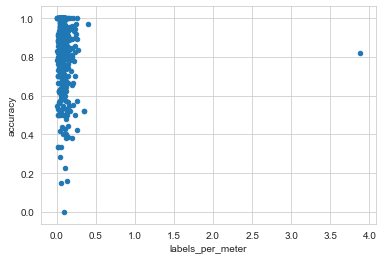

In [314]:
# We can use Pandas to create a scatter plot directly but hard to color by user group
ax = df_users.plot.scatter(x='labels_per_meter', y='accuracy')

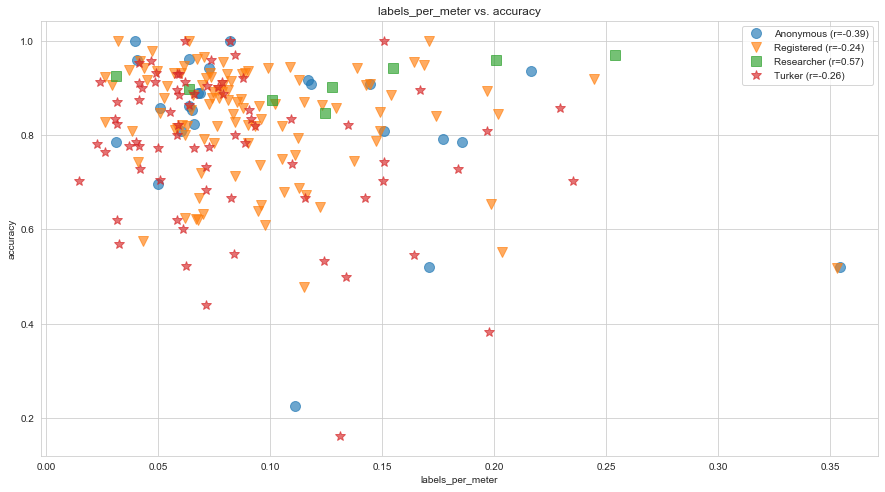

In [375]:
# So I made my own scatter plot. Let's look at the relationship between labels_per_meter and accuracy
plot_scatter(df_users, 'labels_per_meter', 'accuracy');

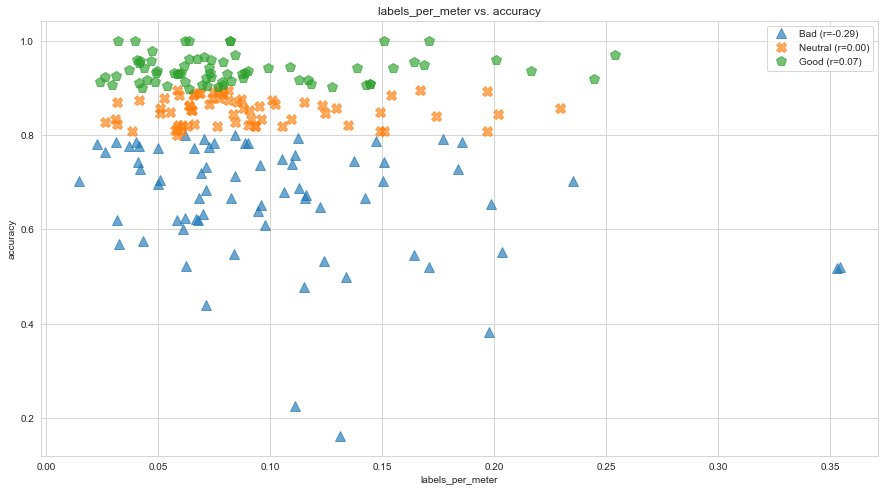

In [376]:
plot_scatter(df_users, 'labels_per_meter', 'accuracy', groupby='user_quality_3bins');

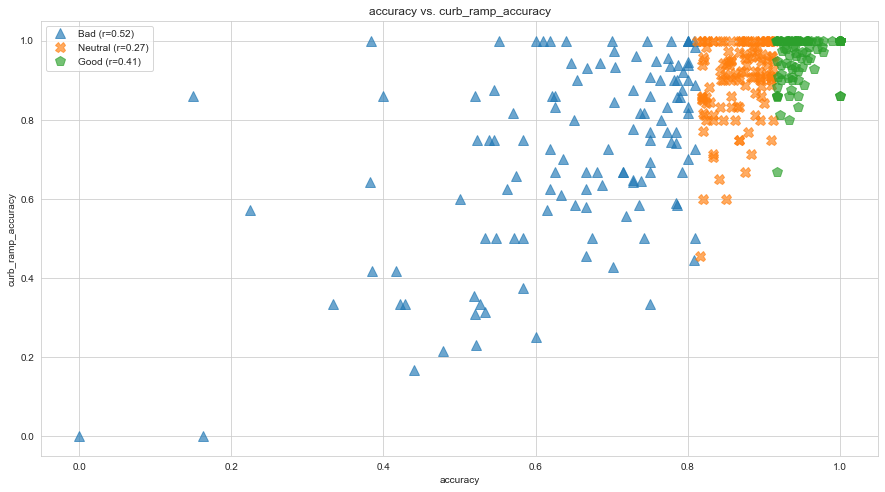

In [426]:
plot_scatter(df_users, 'accuracy', 'curb_ramp_accuracy', groupby='user_quality_3bins');

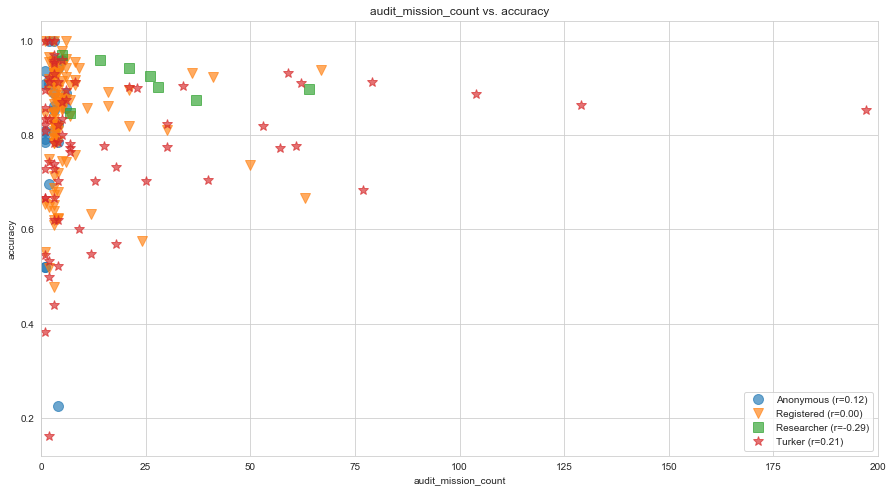

In [377]:
plot_scatter(df_users, 'audit_mission_count', 'accuracy', xlim=(0, 200));

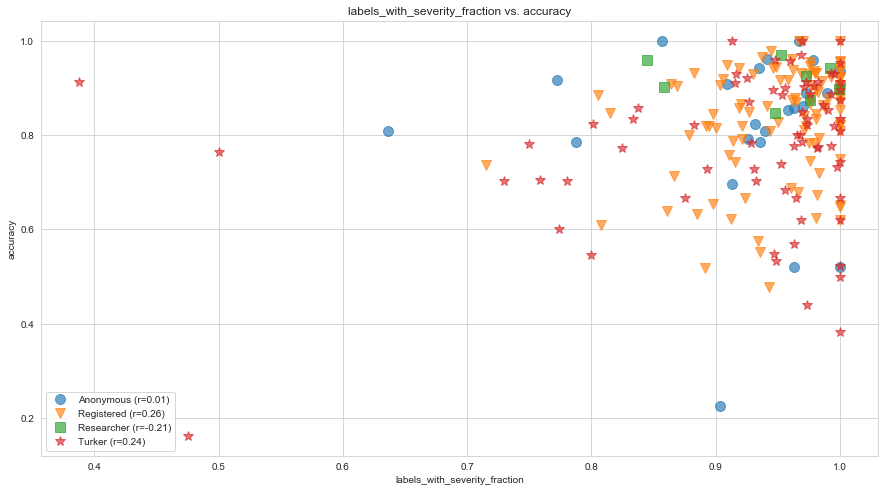

In [378]:
plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy');

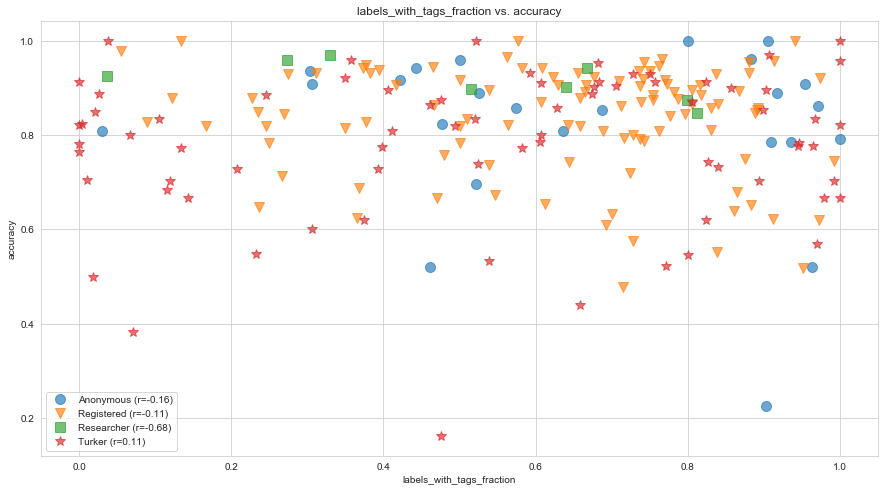

In [379]:
plot_scatter(df_users, 'labels_with_tags_fraction', 'accuracy');

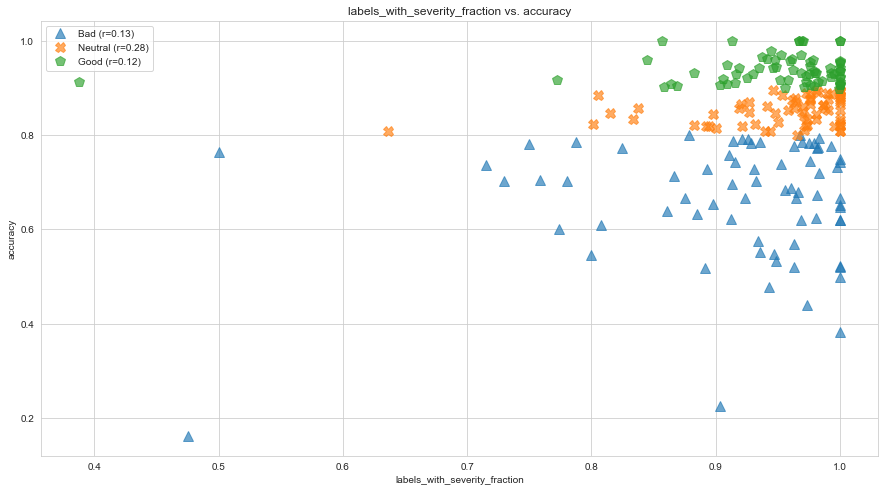

In [380]:
plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy', groupby='user_quality_3bins');

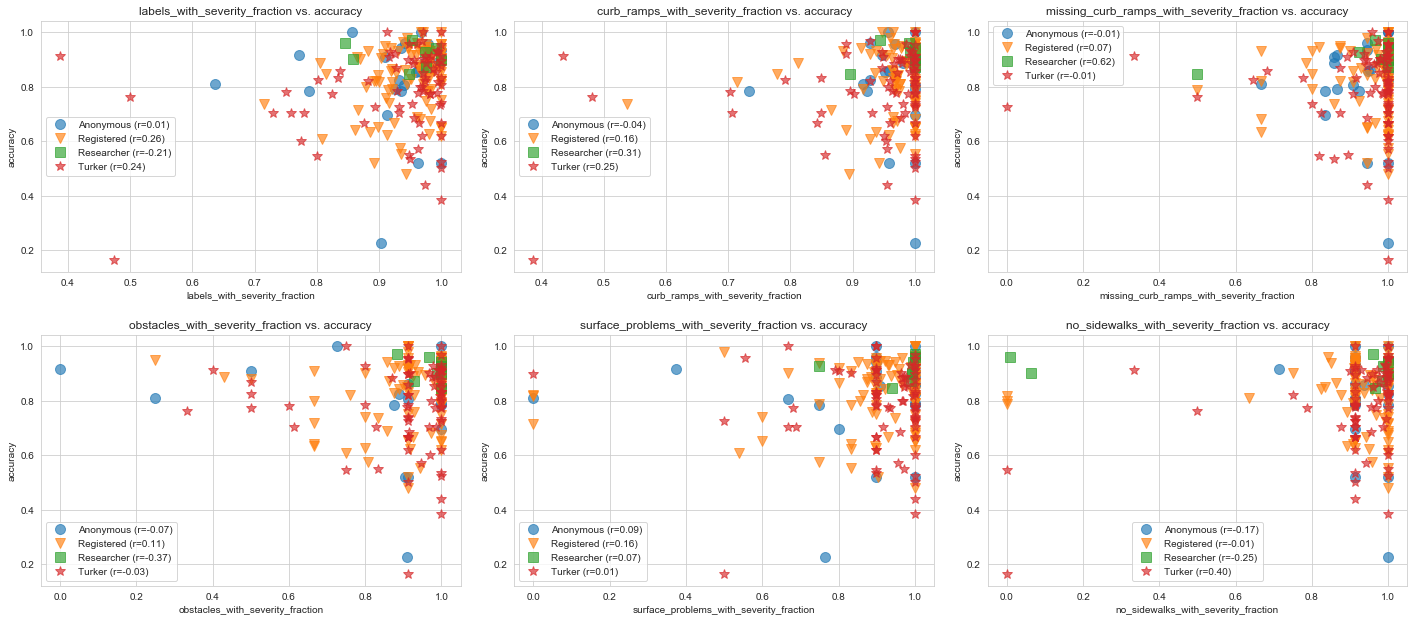

In [381]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy', ax = axes[0][0])
plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])
plt.tight_layout(pad=2)

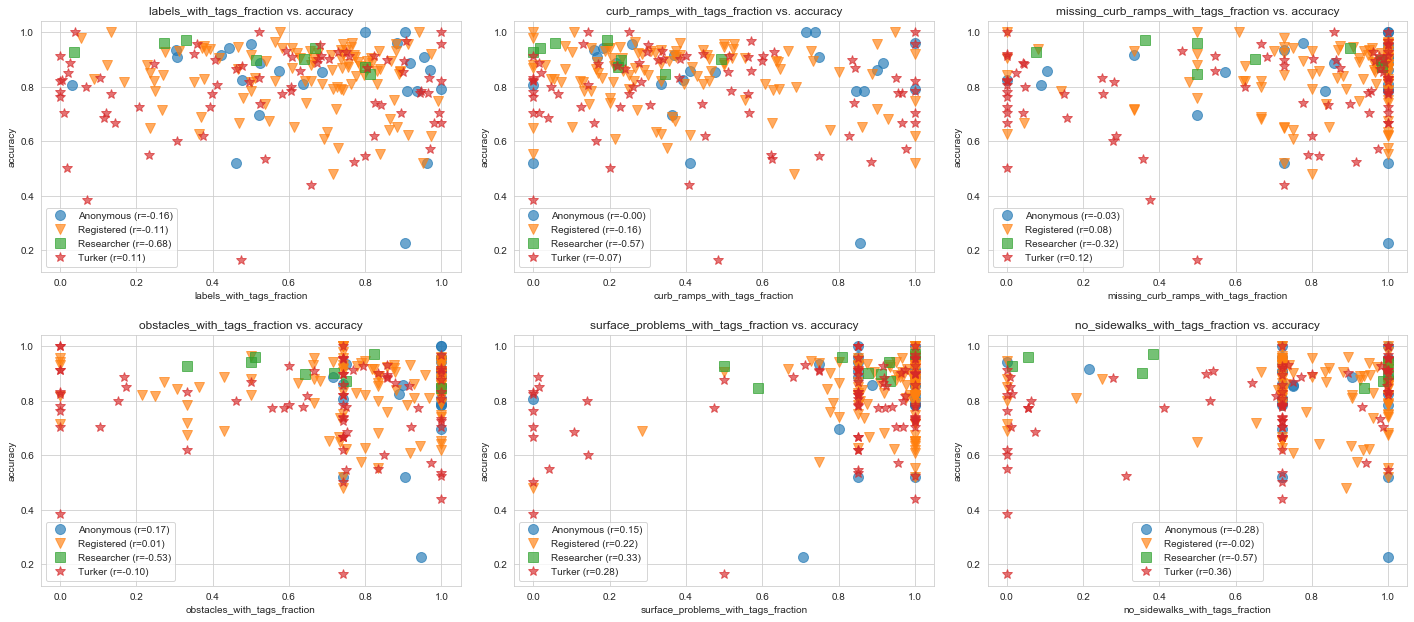

In [382]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

plot_scatter(df_users, 'labels_with_tags_fraction', 'accuracy', ax = axes[0][0])
plot_scatter(df_users, 'curb_ramps_with_tags_fraction', 'accuracy', ax = axes[0][1])
plot_scatter(df_users, 'missing_curb_ramps_with_tags_fraction', 'accuracy', ax = axes[0][2])
plot_scatter(df_users, 'obstacles_with_tags_fraction', 'accuracy', ax = axes[1][0])
plot_scatter(df_users, 'surface_problems_with_tags_fraction', 'accuracy', ax = axes[1][1])
plot_scatter(df_users, 'no_sidewalks_with_tags_fraction', 'accuracy', ax = axes[1][2])
plt.tight_layout(pad=2)

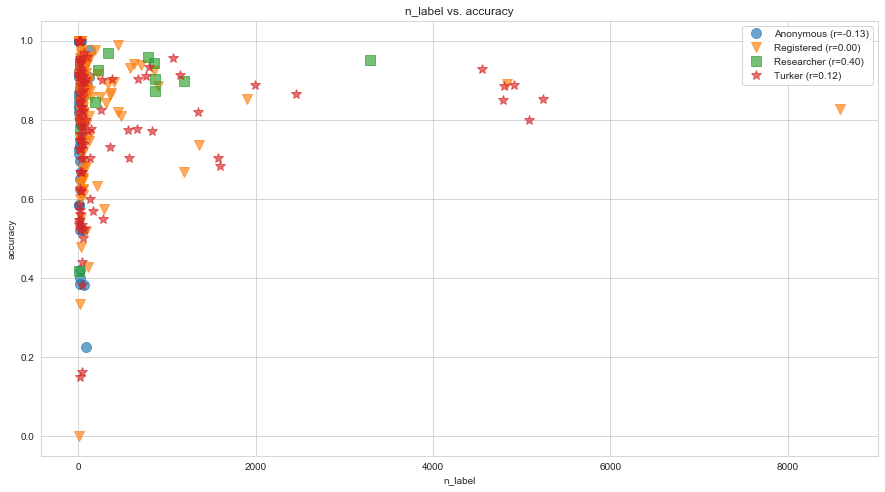

In [338]:
plot_scatter(df_users, 'n_label', 'accuracy');

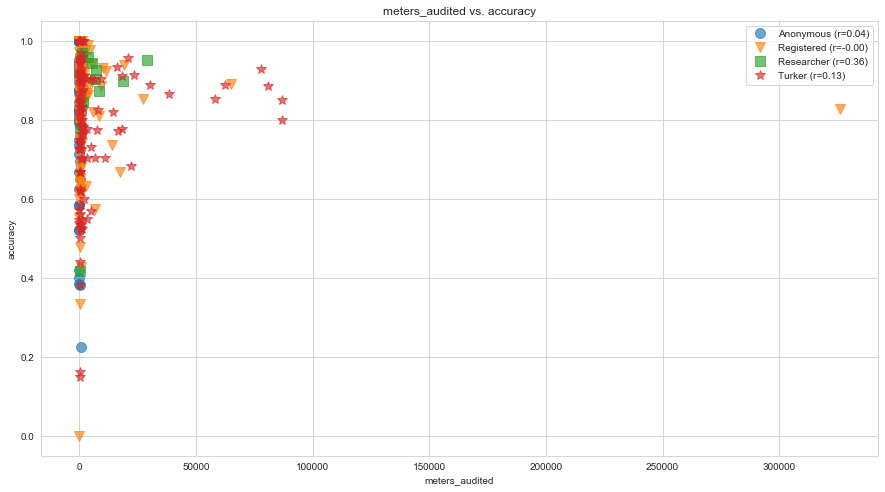

In [336]:
plot_scatter(df_users, 'meters_audited', 'accuracy');

# Accuracy as a function of role

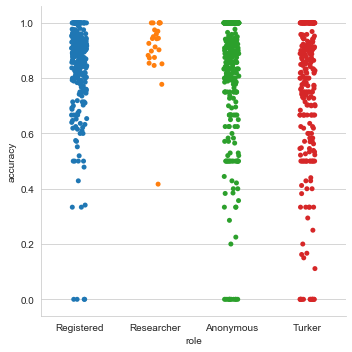

In [418]:
# from: https://seaborn.pydata.org/tutorial/categorical.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
sns.catplot(x="role", y="accuracy", jitter=True, data=df_users);

,num_users,audit_mission_count,meters_audited,n_label,Validations Received,Avg Accuracy,Med Accuracy,SD Accuracy,Bad,Neutral,Good
role,,,,,,,,,,,
Anonymous,24.0,66.0,1.312141e+04,997.0,739.0,0.818575,0.859606,0.177397,7.0,8.0,9.0
Registered,106.0,2073.0,5.703251e+05,26643.0,12629.0,0.834031,0.865152,0.114713,30.0,39.0,37.0
Researcher,8.0,202.0,5.356913e+04,5318.0,2865.0,0.914761,0.914257,0.042768,NaN,2.0,6.0
Turker,74.0,2646.0,7.626165e+05,48611.0,19674.0,0.781305,0.813413,0.156641,35.0,20.0,19.0
Total,212.0,4987.0,1.399632e+06,81569.0,35907.0,0.816924,0.853554,0.139583,72.0,69.0,71.0


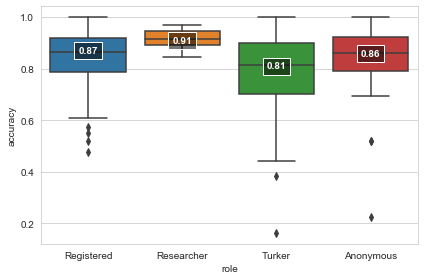

In [384]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot
sns.set_style("whitegrid")
# sns.catplot(x="role", y="accuracy", kind="box", data=df_users, height=6);
box_plot = sns.boxplot(x="role", y="accuracy", data=df_users)

# add in values
# from: https://stackoverflow.com/a/56879116
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0], 2) 

    ax.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold', 
        size=10, color='w', bbox=dict(facecolor='#00000088'))

box_plot.figure.tight_layout()
display_overview(df_users)

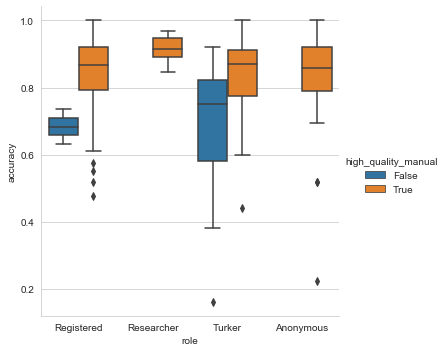

In [385]:
sns.catplot(x="role", y="accuracy", kind="box", hue='high_quality_manual', data=df_users);

## Histograms

### Histogram of accuracy

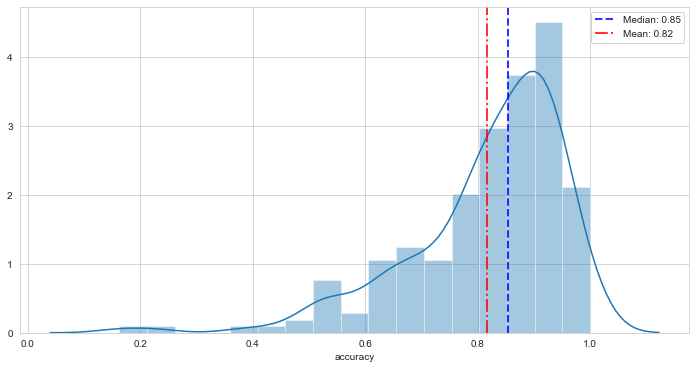

In [386]:
import seaborn as sns, numpy as np

plt.figure(figsize=(12, 6))
ax = sns.distplot(df_users['accuracy'])
plt.axvline(np.median(df_users['accuracy']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['accuracy']):0.2f}", linewidth=2, alpha=0.8)
plt.axvline(np.mean(df_users['accuracy']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['accuracy']):0.2f}", linewidth=2, alpha=0.8)
plt.legend();

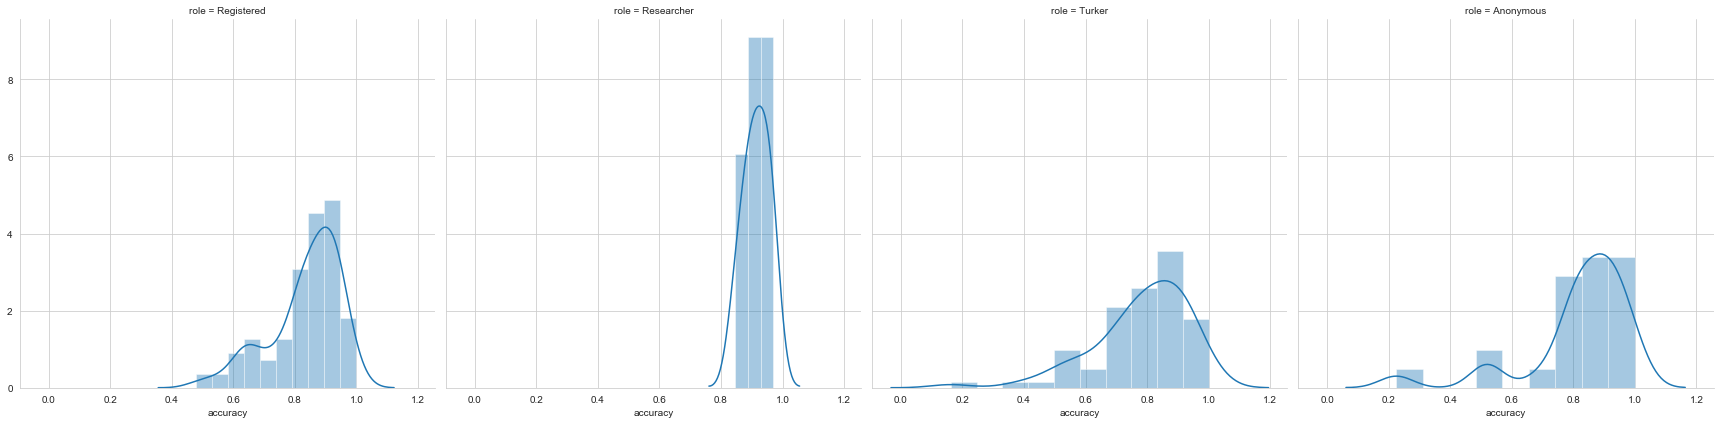

In [387]:
# https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/
g = sns.FacetGrid(df_users, row=None, col='role', height = 6)
g.map(sns.distplot, "accuracy")
plt.show()

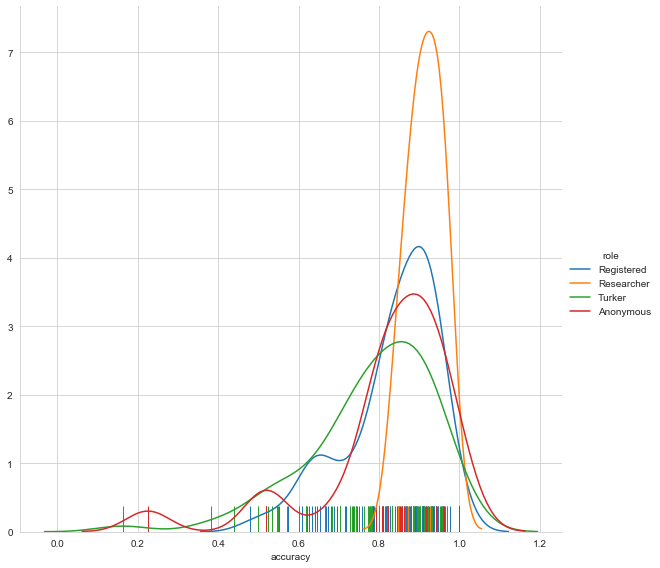

In [388]:
# fig, ax = plt.subplots(figsize=(10, 8))
g = sns.FacetGrid(df_users, hue="role", height=8)
g = g.map(sns.distplot, "accuracy",  hist=False, rug=True);
g.add_legend()

### Histogram of labels/meter

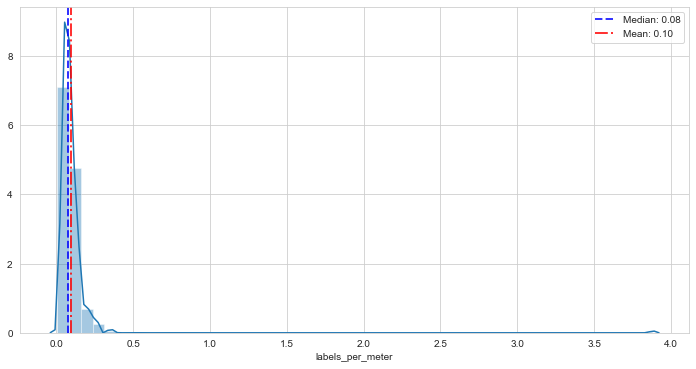

In [121]:
plt.figure(figsize=(12, 6))
col = 'labels_per_meter'
ax = sns.distplot(df_users[col])
plt.axvline(np.median(df_users[col]), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users[col]):0.2f}", linewidth=2, alpha=0.8)
plt.axvline(np.mean(df_users[col]), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users[col]):0.2f}", linewidth=2, alpha=0.8)
plt.legend();

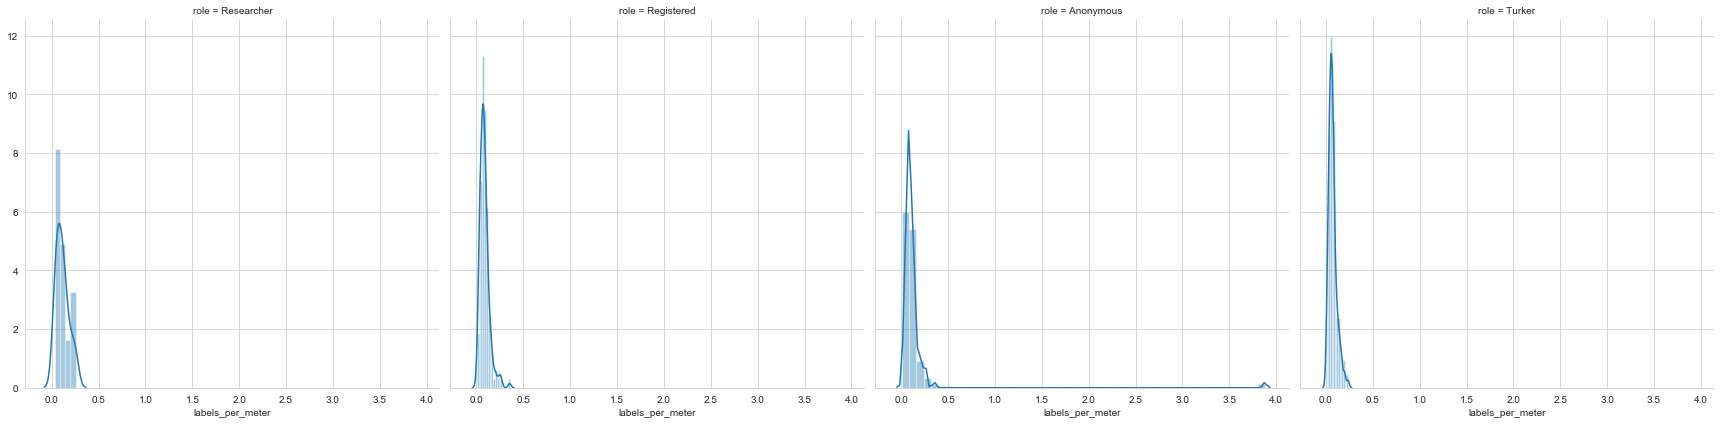

In [120]:
g = sns.FacetGrid(df_users, col='role', height = 6)
g.map(sns.distplot, "labels_per_meter")

## Joint ploints

C:\Users\jonfr\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


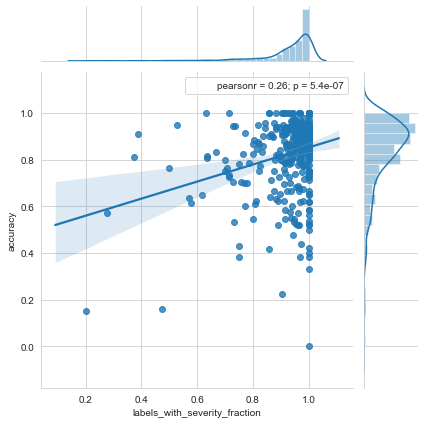

In [344]:
j = sns.jointplot(data=df_users, x='labels_with_severity_fraction', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr) # from: https://stackoverflow.com/a/52119784
plt.show()

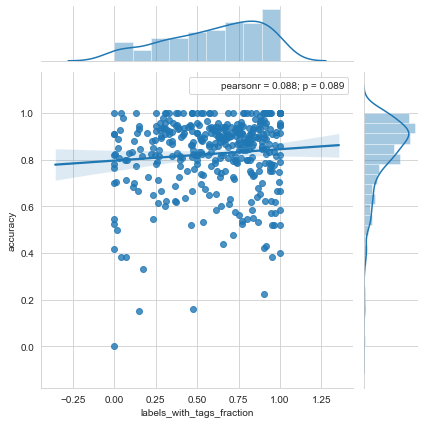

In [345]:
j = sns.jointplot(data=df_users, x='labels_with_tags_fraction', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr) # from: https://stackoverflow.com/a/52119784
plt.show()

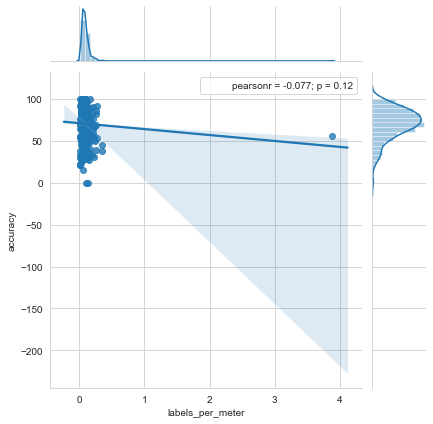

In [124]:
j = sns.jointplot(data=df_users, x='labels_per_meter', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr)
plt.show()

# Regression predictions

In [428]:
# https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
# plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
# plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
# plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
# plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])

input_feature_cols = []

# Add in labels/meter input features
input_feature_cols.extend(['labels_per_meter'])
input_feature_cols.extend(['curb_ramp_labels_per_meter', 'missing_curb_ramp_labels_per_meter', 
                           'obstacle_labels_per_meter', 'surface_problem_labels_per_meter', 'no_sidewalk_labels_per_meter'])

# Add in severity input features
input_feature_cols.extend(['labels_with_severity_fraction'])
input_feature_cols.extend(['missing_curb_ramps_with_severity_fraction',
              'obstacles_with_severity_fraction', 'surface_problems_with_severity_fraction', 
              'curb_ramps_with_severity_fraction', 'no_sidewalks_with_severity_fraction'])

# Add in tag input features
input_feature_cols.extend(['labels_with_tags_fraction'])
input_feature_cols.extend(['missing_curb_ramps_with_tags_fraction',
              'obstacles_with_tags_fraction', 'surface_problems_with_tags_fraction', 
              'curb_ramps_with_tags_fraction', 'no_sidewalks_with_tags_fraction'])

X = df_users[input_feature_cols]

#X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction']]
y = df_users['accuracy'].values

# TODO: update this to be k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
display(coeff_df)

y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(df.sample(10))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

,Coefficient
labels_per_meter,4.595312
curb_ramp_labels_per_meter,-5.136929
missing_curb_ramp_labels_per_meter,-3.874438
obstacle_labels_per_meter,-6.021204
surface_problem_labels_per_meter,-5.132865
no_sidewalk_labels_per_meter,-4.522574
labels_with_severity_fraction,0.519968
missing_curb_ramps_with_severity_fraction,-0.060610
obstacles_with_severity_fraction,-0.069537
surface_problems_with_severity_fraction,-0.038159


,Actual,Predicted
21,0.666667,0.662343
54,0.942857,0.841033
2,0.941176,0.858665
71,0.931034,0.868534
8,0.863636,0.853073
45,0.940299,0.816400
25,0.548148,0.894863
0,0.666667,0.846333
16,0.916667,0.856782
51,0.574468,0.837744


Mean Absolute Error: 0.10842763308051948
Root Mean Squared Error: 0.15721183992298485


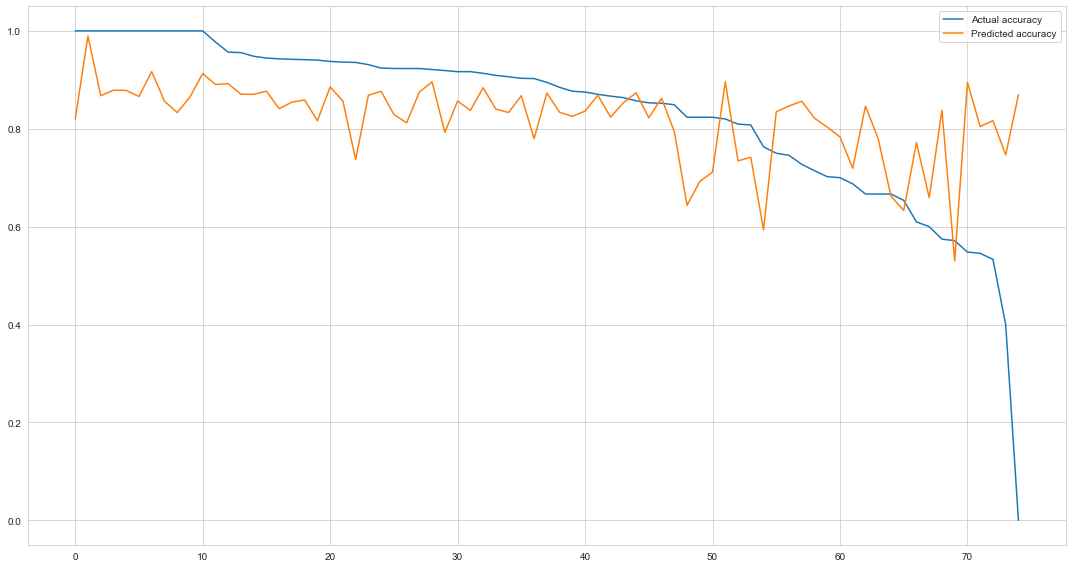

In [429]:
sorted_indices = y_test.argsort()[::-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(y_test[sorted_indices], label="Actual accuracy")
ax.plot(y_pred[sorted_indices], label="Predicted accuracy")
ax.legend()
fig.tight_layout()

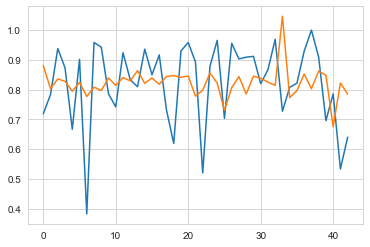

In [390]:
plt.plot(y_test)
plt.plot(y_pred)

# User classification

In [430]:
from sklearn import svm
from sklearn.metrics import accuracy_score

df_users["user_quality_3bins"] = df_users["user_quality_3bins"].astype('category')
df_users["user_quality_3bins_cat"] = df_users["user_quality_3bins"].cat.codes

# X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction',
#               'missing_curb_ramps_with_severity_fraction',
#               'obstacles_with_severity_fraction', 'surface_problems_with_severity_fraction', 
#               'curb_ramps_with_severity_fraction', 'no_sidewalks_with_severity_fraction']]
#X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'labels_with_tags_fraction']]
y = df_users['user_quality_3bins']

# display(X)
# display(y)

# TODO: update this to be k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.37333333333333335

Overall SVM accuracy: 44.77%
              precision    recall  f1-score   support

         Bad       0.51      0.42      0.46       125
        Good       0.43      0.64      0.51       124
     Neutral       0.41      0.29      0.34       124

    accuracy                           0.45       373
   macro avg       0.45      0.45      0.44       373
weighted avg       0.45      0.45      0.44       373



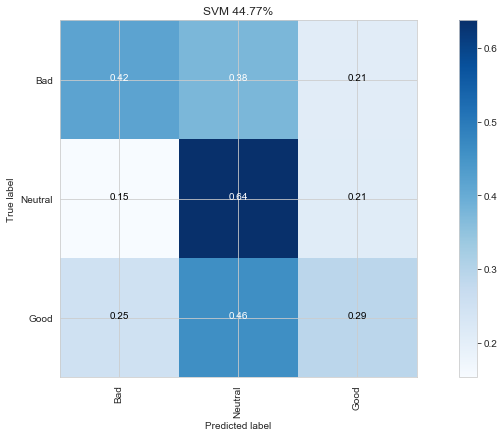

In [431]:
kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

clf = svm.SVC(kernel='linear', C=1)
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall SVM accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
graph_title = f"SVM {accuracy_score(y, y_pred) * 100:.2f}%"
plot_confusion_matrix(cm, classes = ["Bad", "Neutral", "Good"], title=graph_title, normalize=True)
# grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

In [134]:
df_users.groupby('quality_3bins').describe()

validations_received_count                                      \
                                   count        mean         std   min   25%   
quality_3bins                                                                  
Bad                                137.0   76.751825  170.858721  11.0  18.0   
Neutral                            141.0  168.049645  412.948619  11.0  23.0   
Good                               132.0  142.030303  399.523112  11.0  14.0   

                                   accuracy             ...  \
                50%    75%     max    count       mean  ...   
quality_3bins                                           ...   
Bad            30.0   68.0  1519.0    137.0  50.507683  ...   
Neutral        42.0  102.0  2785.0    141.0  73.111286  ...   
Good           23.0   56.5  2921.0    132.0  88.706088  ...   

              surface_problems_with_severity_fraction       \
                                                  75%  max   
quality_3bins                                                
Bad                                               1.0  1.0   
Neutral                                           1.0  1.0   
Good                                              1.0  1.0   

              no_sidewalks_with_severity_fraction                           \
                                            count      mean       std  min   
quality_3bins                                                                
Bad                                         137.0  0.851576  0.247911  0.0   
Neutral                                     141.0  0.911000  0.150522  0.0   
Good                                        132.0  0.921587  0.114386  0.0   

                                             
                    25%       50%  75%  max  
quality_3bins                                
Bad            0.894552  0.894552  1.0  1.0  
Neutral        0.894552  0.911111  1.0  1.0  
Good           0.894552  0.894552  1.0  1.0  

[3 rows x 192 columns]

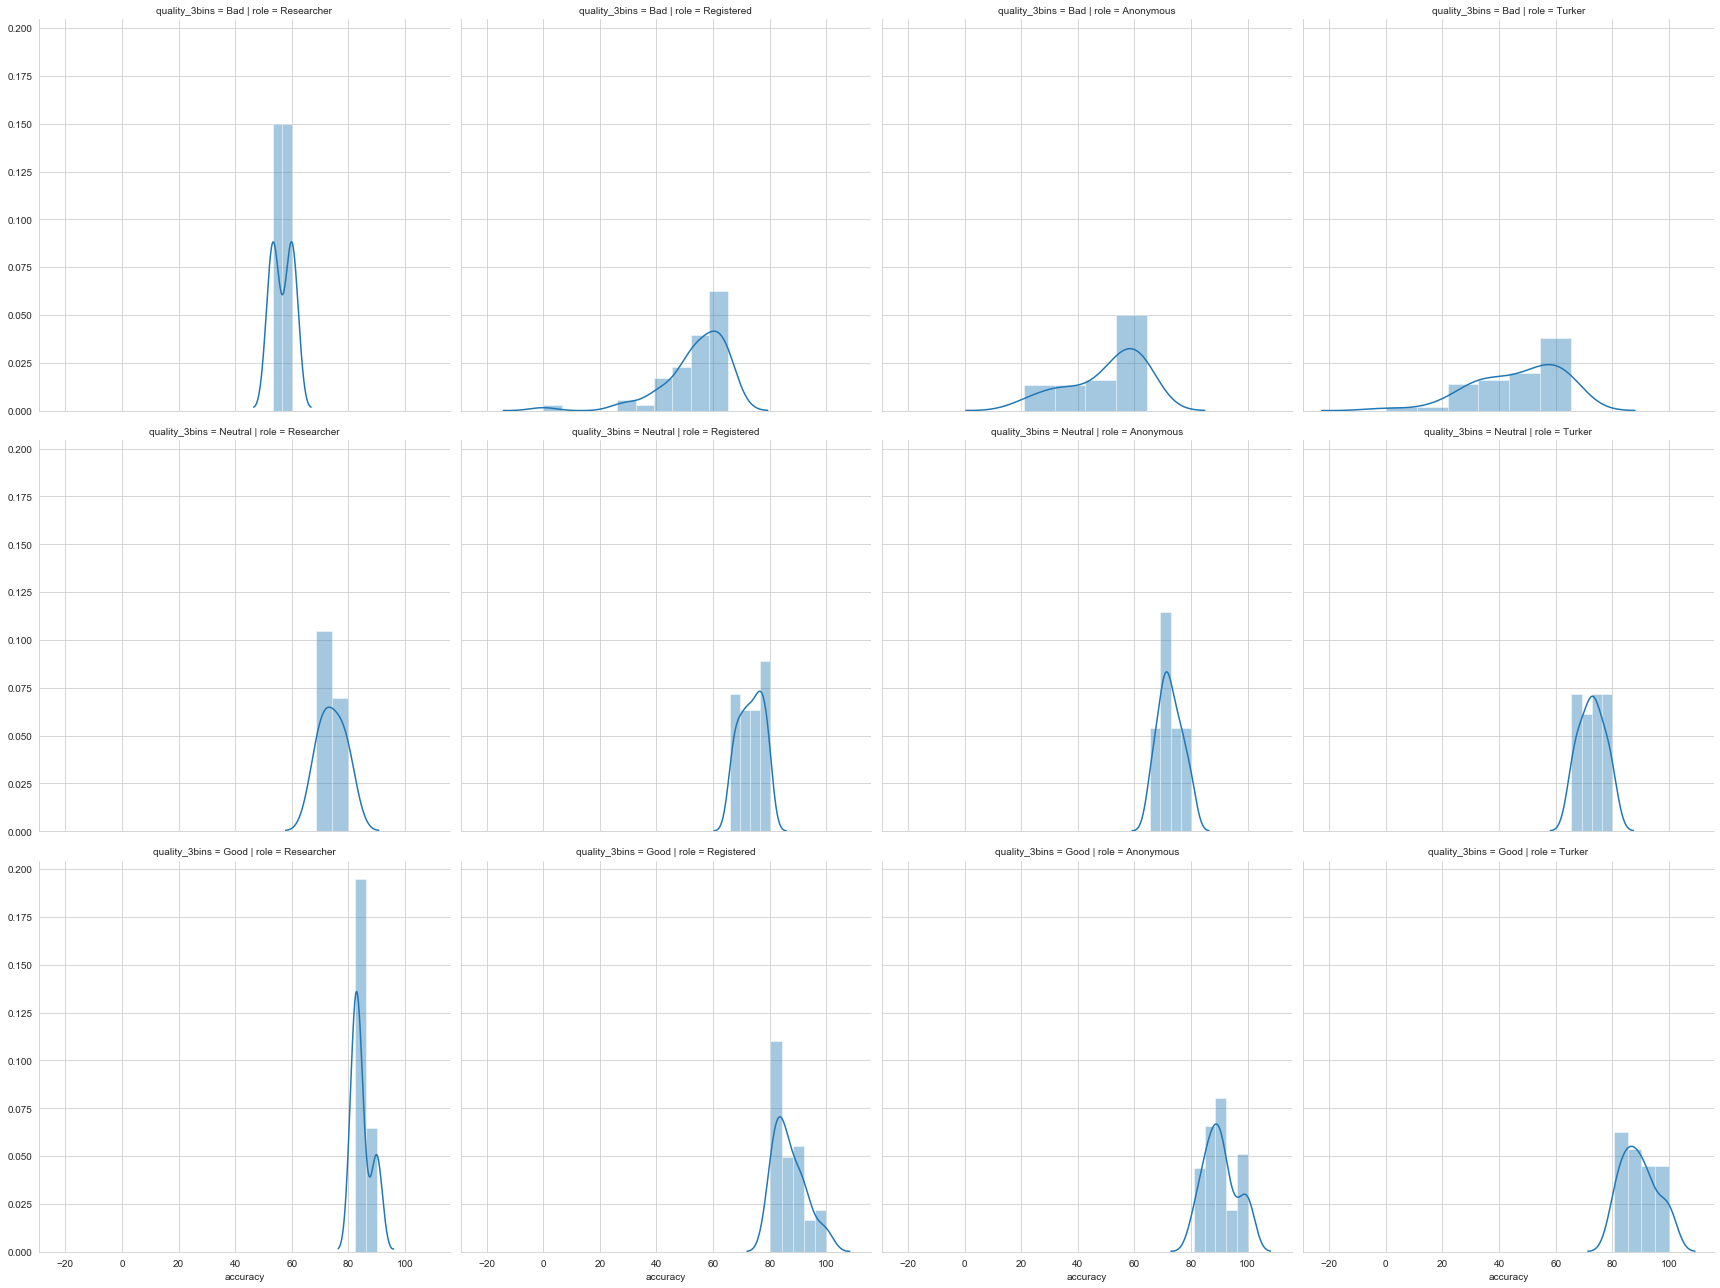

In [133]:
g = sns.FacetGrid(df_users, row='quality_3bins', col='role', height = 6)
g.map(sns.distplot, "accuracy")
plt.show()

# Sandbox

## Pairwise correlations

Text(0.5, 1, 'Pairwise correlation of input features')

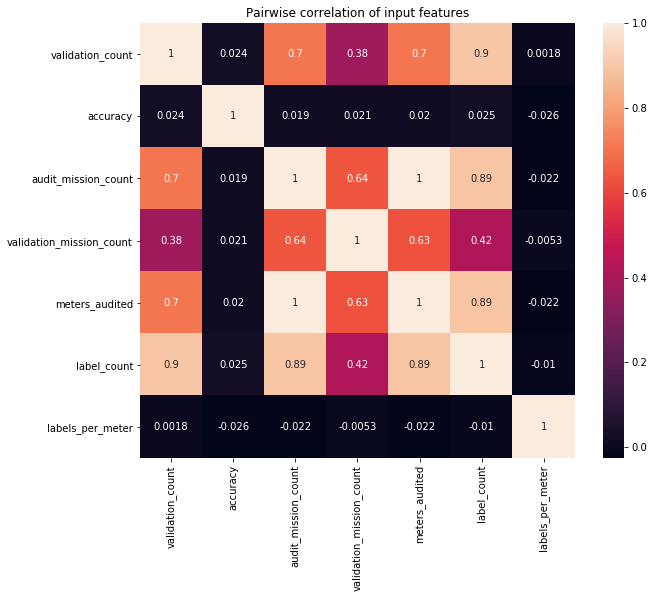

In [118]:
pairwise_corr = df_users.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_corr, square=True, annot=True)
plt.title(f"Pairwise correlation of input features")

## Pairplots

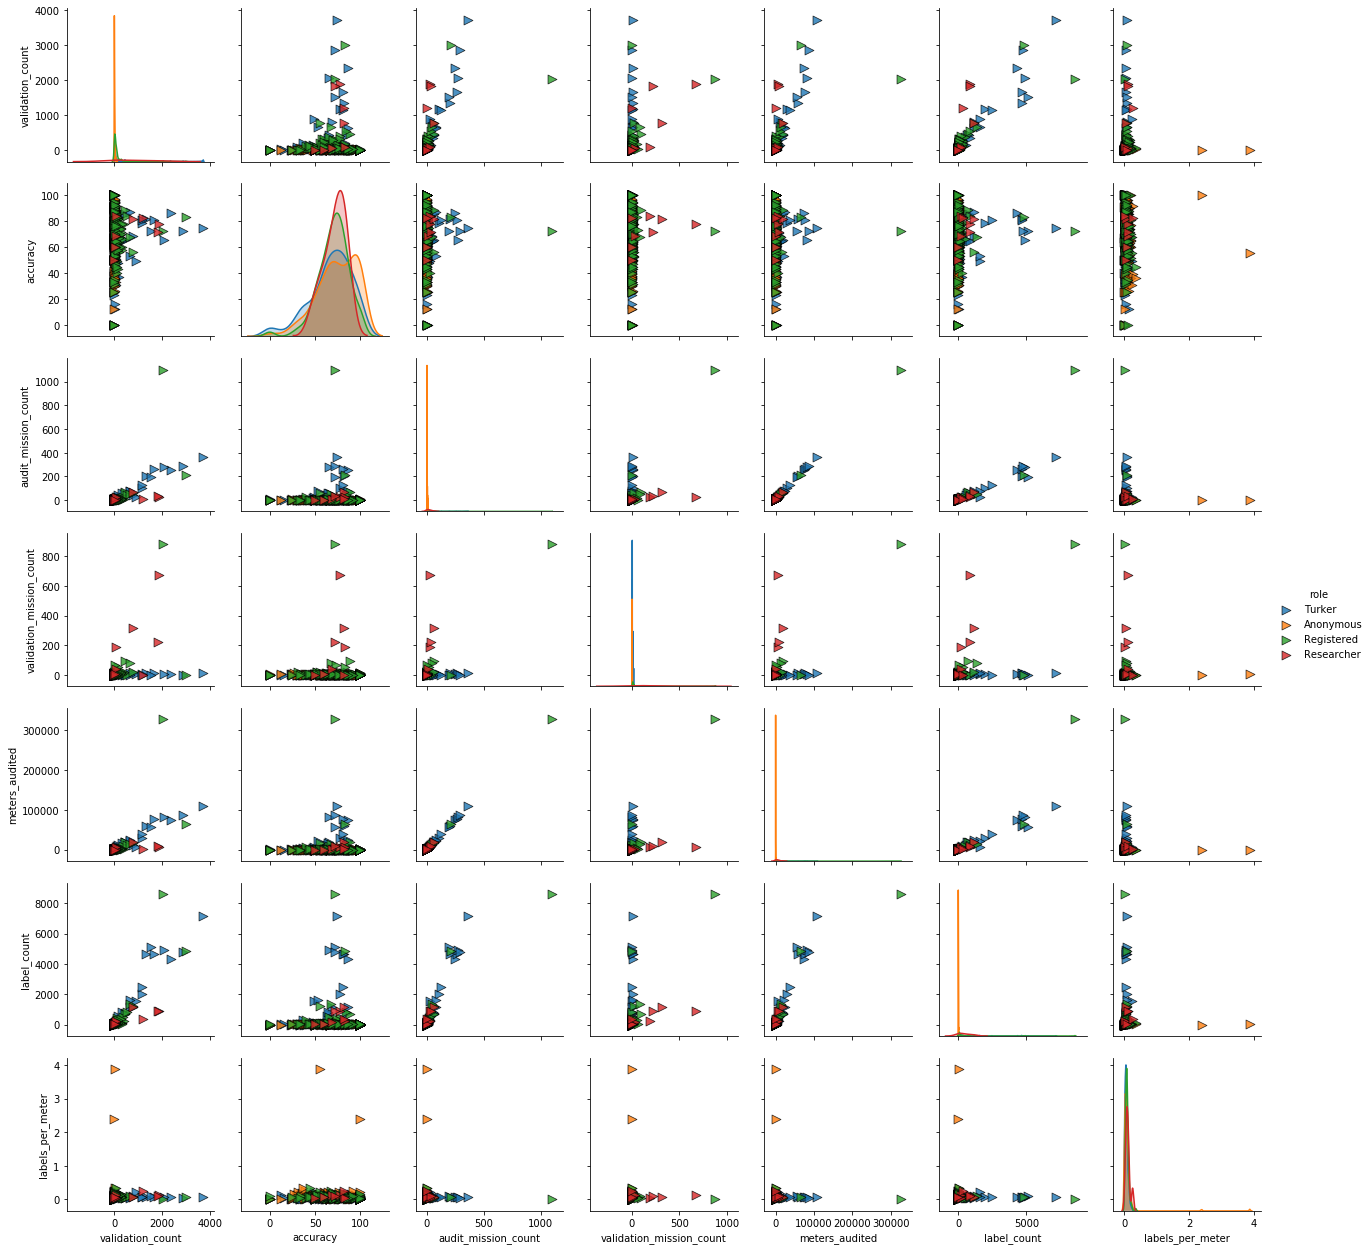

In [122]:
# Create the pairplot (this might take a bit of time)
markers = plot_markers[4]
sns.pairplot(df_users, hue="role", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);